In [ ]:
# GENERAL WORKFLOW AS OF 2025-02-13

# all this needs to be updated to use a wrapper

# 1. import libraries
# 2. load data
# 3. select rows and cols to keep
# 4. run proxy_imputation()
# 5. run wide_to_long()
# 6. expand feature vector so that each feature gets its own column
# 7. split dataframe into separate csv files, one for each event_type
# 8. update subjects.csv so that it has one row for each subject_id
# 9. specify csv files in the config file for build_datasets.py in ESGPT

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
# import seaborn as sns
# import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
print(os.getcwd())

/home/filip-marcus


/home/filip-marcus/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/filip-marcus/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Utility functions

In [3]:
def unix_to_datetime(unix_time):
    """
    Converts a unix timestamp to a datetime object with format yyyy-mm-dd.
    Note that UTC time is used.
    
    Args:
        unix_time: int of Unix timestamp
        
    Returns:
        datetime: a datetime object with format yyyy-mm-dd
    """
    
    timestamp = pd.to_datetime(unix_time, unit='s')

    return timestamp.strftime("%Y-%m-%d %H:%M:%S")

def get_event_sequence(data_df, first_date, last_date):
    """
    Fetches all events in data_df between first_date and last_date.
    data_df must contain columns 'date' and 'events'
    
    Args:
        data_df: pd.DataFrame input dataframe
        first_date: datetime of first date to be included in the event sequence
        last_data: datetime of last date to be included in the event sequence
        
    Returns:
        List of event sequence. First element is prediction time, then there is one element for each event.
        Each event element in the list can contain some other structure (list).
    """
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], unit='s')
    data_df['timestamp'] = data_df['timestamp'].dt.to_pydatetime()
    
    filtered_df = data_df[(data_df['timestamp'] >= first_date) & (data_df['timestamp'] <= last_date)]
        
    event_sequence = []
    event_sequence.append(last_date)

    for _, row in filtered_df.iterrows():
        event = row['features']
        event_time = row['timestamp']
#         event_class = row['PQ class']
        # event_class = 'simple_event'
        event_class = row["event_label"]
        event_sequence.append([event_time, event_class, event])
        
    return event_sequence
        
    
def get_label(data_df, timestamp):
    """
    Returns the class label for the event at date
    """
    timestamp = pd.to_datetime(timestamp)
    
    df = data_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('S')
    
    row = data_df[data_df['timestamp'] == timestamp]
    
    if not row.empty:
        return row['PQ class'].iloc[0]
    else:
        return 'Timestamp not found in dataframe'

def wide_to_long_df(df):

    long_format_data = []

    for idx, row in df.iterrows():
        
        for col in range(1,len(row)):
            event = row[col]
            
            if type(event) == float: # skip nan values
                continue
            
            else:
                # each event is of the form [timestamp, label, feature_vector]
                # print(event)
                timestamp, label, feature_vector = event

            event_dict = {
                "sequence_id": idx,
                "event_idx": col-1,
                "timestamp": timestamp,
                "event_label": label,
                "feature_vector": feature_vector
            }

            long_format_data.append(event_dict)

    long_df = pd.DataFrame(long_format_data)
    
    return long_df

    

# Load Eneryield data

## JO3

#### Classification

In [9]:
# Path to csv file containing event data
raw_cls_data_path = '/home/filip-marcus/data/db_access/data/J03/classification/2025_january_classification_model.csv'

# Read csv as pd.DataFrame
cls_data_df = pd.read_csv(raw_cls_data_path)
cls_data_df.head()

,sample_id,PQ class,Root Cause 1,Root Cause 2,timestamp
0,1,interruption,unknown,unknown,1.601986e+09
1,2,VD,unknown,unknown,1.601986e+09
2,3,unbalance_u,unknown,unknown,1.601986e+09
3,4,unbalance_u,unknown,unknown,1.601986e+09
4,5,unbalance_u,unknown,unknown,1.601988e+09


In [10]:
no_rows_to_keep = cls_data_df.shape[0] # all rows

# keep only PQ class and timestamp
df_pqclass = cls_data_df.iloc[:no_rows_to_keep, [1,4]]

# create list of all unique classes in the selected data
unique_classes = df_pqclass['PQ class'].unique().tolist()   # filter out some classes? such as interruption/ongoing_interruption
print('Classes in this selection: ', unique_classes)

Classes in this selection:  ['interruption', 'VD', 'unbalance_u', 'transient', 'interruption end', 'normal', 'current_deviation', 'unbalance_i', 'ongoing interruption', 'harmonics_i', 'harmonics_u']


#### Scalars

In [11]:
raw_scalars_data_path = '/home/filip-marcus/data/db_access/data/J03/scalars.csv'
df_scalars = pd.read_csv(raw_scalars_data_path)

# Keep some number of scalars
no_scalars_to_keep = 50
# df_scalars = df_scalars.iloc[:no_rows_to_keep, :no_scalars_to_keep + 4]

# Keep some subset of scalars
manual_small_collection = [
    "sample_id",
    "timestamp",
    "rms_I0_max",
    "rms_I1_max",
    "rms_I2_max",
    "rms_I3_max",
    "rms_U0_max",
    "rms_U1_max",
    "rms_U2_max",
    "rms_U3_max",
    "rms_I0_min",
    "rms_I1_min",
    "rms_I2_min",
    "rms_I3_min",
    "rms_U0_min",
    "rms_U1_min",
    "rms_U2_min",
    "rms_U3_min",
    "fft_U0_thdf",
    "fft_U1_thdf",
    "fft_U2_thdf",
    "fft_U3_thdf",
    "fft_I0_thdf",
    "fft_I1_thdf",
    "fft_I2_thdf",
    "fft_I3_thdf",
    "impedance_integral_Phase_1_definite_integral",
    "impedance_integral_Phase_2_definite_integral",
    "impedance_integral_Phase_3_definite_integral",
]


manual_medium_collection = [
    "sample_id",
    "timestamp",
    "I_initial_amplitude",
    "U_initial_amplitude",
    "rms_I0_max",
    "rms_I1_max",
    "rms_I2_max",
    "rms_I3_max",
    "rms_U0_max",
    "rms_U1_max",
    "rms_U2_max",
    "rms_U3_max",
    "rms_I0_min",
    "rms_I1_min",
    "rms_I2_min",
    "rms_I3_min",
    "rms_U0_min",
    "rms_U1_min",
    "rms_U2_min",
    "rms_U3_min",
    "rms_integral_I0_definite_integral",
    "rms_integral_I1_definite_integral",
    "rms_integral_I2_definite_integral",
    "rms_integral_I3_definite_integral",
    "rms_integral_U0_definite_integral",
    "rms_integral_U1_definite_integral",
    "rms_integral_U2_definite_integral",
    "rms_integral_U3_definite_integral",
    "apparent_power_integral_Phase_0_definite_integral",
    "apparent_power_integral_Phase_1_definite_integral",
    "apparent_power_integral_Phase_2_definite_integral",
    "apparent_power_integral_Phase_3_definite_integral",
    "impedance_integral_Phase_1_definite_integral",
    "impedance_integral_Phase_2_definite_integral",
    "impedance_integral_Phase_3_definite_integral",
    "impedance_Phase_1_max",
    "impedance_Phase_2_max",
    "impedance_Phase_3_max",
    "impedance_Phase_1_min",
    "impedance_Phase_2_min",
    "impedance_Phase_3_min",
    "resistance_integral_Phase_1_definite_integral",
    "resistance_integral_Phase_2_definite_integral",
    "resistance_integral_Phase_3_definite_integral",
    "reactance_integral_Phase_1_definite_integral",
    "reactance_integral_Phase_2_definite_integral",
    "reactance_integral_Phase_3_definite_integral",
    "fft_U0_thdf",
    "fft_U1_thdf",
    "fft_U2_thdf",
    "fft_U3_thdf",
    "fft_I0_thdf",
    "fft_I1_thdf",
    "fft_I2_thdf",
    "fft_I3_thdf",
    "spm_integral_I_definite_integral",
    "spm_integral_U_definite_integral",
]


manual_large_collection = [
    "sample_id",
    "timestamp",
    "I_initial_amplitude",
    "U_initial_amplitude",
    "rms_integral_I0_definite_integral",
    "rms_integral_I1_definite_integral",
    "rms_integral_I2_definite_integral",
    "rms_integral_I3_definite_integral",
    "rms_integral_U0_definite_integral",
    "rms_integral_U1_definite_integral",
    "rms_integral_U2_definite_integral",
    "rms_integral_U3_definite_integral",
    "phase_shift_I1_range",
    "phase_shift_I2_range",
    "phase_shift_I3_range",
    "phase_shift_U1_range",
    "phase_shift_U2_range",
    "phase_shift_U3_range",
    "relative_phase_I1_I2_std",
    "relative_phase_I1_I3_std",
    "relative_phase_I2_I3_std",
    "relative_phase_U1_U2_std",
    "relative_phase_U1_U3_std",
    "relative_phase_U2_U3_std",
    "rms_derivative_I0_max",
    "rms_derivative_I1_max",
    "rms_derivative_I2_max",
    "rms_derivative_I3_max",
    "rms_derivative_U0_max",
    "rms_derivative_U1_max",
    "rms_derivative_U2_max",
    "rms_derivative_U3_max",
    "rms_derivative_I0_min",
    "rms_derivative_I1_min",
    "rms_derivative_I2_min",
    "rms_derivative_I3_min",
    "rms_derivative_U0_min",
    "rms_derivative_U1_min",
    "rms_derivative_U2_min",
    "rms_derivative_U3_min",
    "apparent_power_integral_Phase_0_definite_integral",
    "apparent_power_integral_Phase_1_definite_integral",
    "apparent_power_integral_Phase_2_definite_integral",
    "apparent_power_integral_Phase_3_definite_integral",
    "apparent_power_Phase_0_max",
    "apparent_power_Phase_1_max",
    "apparent_power_Phase_2_max",
    "apparent_power_Phase_3_max",
    "apparent_power_Phase_0_min",
    "apparent_power_Phase_1_min",
    "apparent_power_Phase_2_min",
    "apparent_power_Phase_3_min",
    "impedance_integral_Phase_1_definite_integral",
    "impedance_integral_Phase_2_definite_integral",
    "impedance_integral_Phase_3_definite_integral",
    "impedance_Phase_1_max",
    "impedance_Phase_2_max",
    "impedance_Phase_3_max",
    "impedance_Phase_1_min",
    "impedance_Phase_2_min",
    "impedance_Phase_3_min",
    "resistance_integral_Phase_1_definite_integral",
    "resistance_integral_Phase_2_definite_integral",
    "resistance_integral_Phase_3_definite_integral",
    "reactance_integral_Phase_1_definite_integral",
    "reactance_integral_Phase_2_definite_integral",
    "reactance_integral_Phase_3_definite_integral",
    "measurements_transform_subtract_previous_cycle_I1_rmse",
    "measurements_transform_subtract_previous_cycle_I2_rmse",
    "measurements_transform_subtract_previous_cycle_I3_rmse",
    "measurements_transform_subtract_previous_cycle_U1_rmse",
    "measurements_transform_subtract_previous_cycle_U2_rmse",
    "measurements_transform_subtract_previous_cycle_U3_rmse",
    "fft_I1_harmonic_1",
    "fft_I2_harmonic_1",
    "fft_I3_harmonic_1",
    "fft_U1_harmonic_1",
    "fft_U2_harmonic_1",
    "fft_U3_harmonic_1",
    "fft_I1_harmonic_2",
    "fft_I2_harmonic_2",
    "fft_I3_harmonic_2",
    "fft_U1_harmonic_2",
    "fft_U2_harmonic_2",
    "fft_U3_harmonic_2",
    "fft_I1_harmonic_3",
    "fft_I2_harmonic_3",
    "fft_I3_harmonic_3",
    "fft_U1_harmonic_3",
    "fft_U2_harmonic_3",
    "fft_U3_harmonic_3",
    "fft_I1_harmonic_4",
    "fft_I2_harmonic_4",
    "fft_I3_harmonic_4",
    "fft_U1_harmonic_4",
    "fft_U2_harmonic_4",
    "fft_U3_harmonic_4",
    "fft_I1_harmonic_5",
    "fft_I2_harmonic_5",
    "fft_I3_harmonic_5",
    "fft_U1_harmonic_5",
    "fft_U2_harmonic_5",
    "fft_U3_harmonic_5",
    "fft_I1_harmonic_6",
    "fft_I2_harmonic_6",
    "fft_I3_harmonic_6",
    "fft_U1_harmonic_6",
    "fft_U2_harmonic_6",
    "fft_U3_harmonic_6",
    "fft_I1_harmonic_7",
    "fft_I2_harmonic_7",
    "fft_I3_harmonic_7",
    "fft_U1_harmonic_7",
    "fft_U2_harmonic_7",
    "fft_U3_harmonic_7",
    "fft_I1_harmonic_8",
    "fft_I2_harmonic_8",
    "fft_I3_harmonic_8",
    "fft_U1_harmonic_8",
    "fft_U2_harmonic_8",
    "fft_U3_harmonic_8",
    "fft_I1_harmonic_9",
    "fft_I2_harmonic_9",
    "fft_I3_harmonic_9",
    "fft_U1_harmonic_9",
    "fft_U2_harmonic_9",
    "fft_U3_harmonic_9",
    "fft_I1_harmonic_10",
    "fft_I2_harmonic_10",
    "fft_I3_harmonic_10",
    "fft_U1_harmonic_10",
    "fft_U2_harmonic_10",
    "fft_U3_harmonic_10",
    "spm_integral_I_definite_integral",
    "spm_integral_U_definite_integral",
]

df_scalars = df_scalars[manual_small_collection]
# df_scalars = df_scalars.iloc[:no_rows_to_keep, :5]
df_scalars.shape

(78016, 29)

#### Merge scalars and class DataFrames

In [12]:
# merge the dataframes on timestamp
data_df = pd.merge(df_scalars, df_pqclass, on = 'timestamp', how = 'inner')

# add all features to a list, and place this list in a column called features
feature_cols = data_df.columns[4:-1]
data_df['features'] = data_df[feature_cols].apply(lambda row: row.tolist(), axis=1)

# remove feature columns after they are combined to list
data_df = data_df.drop(columns = feature_cols)
data_df = data_df.drop(data_df.columns[[0, 2, 3]], axis=1)

print('data_df shape: ', data_df.shape)
# data_df['is_interruption'] = (data_df['PQ class'] == 'interruption').astype(int)
data_df.head()

data_df shape:  (78026, 3)


,timestamp,PQ class,features
0,1.601986e+09,interruption,"[120.9818644784, 106.6533229807, 0.0450764024,..."
1,1.601986e+09,VD,"[25.4995054006, 66.254183138, 0.060216956, 0.7..."
2,1.601986e+09,unbalance_u,"[0.736997181, 0.6437838372, 0.0259733392, 0.68..."
3,1.601986e+09,unbalance_u,"[0.7440775213, 0.6484118803, 0.026043639, 0.68..."
4,1.601988e+09,unbalance_u,"[1.4184988322, 1.5421083585, 0.0270025499, 0.6..."


### NEW ENERYIELD 2025-04-08

In [13]:
# REMOVE EVENT_LABEL == NORMAL
# data_df = data_df[data_df["PQ class"] != "normal"]

# Convert unix to datetime
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'].apply(unix_to_datetime))

train_df_expanded = data_df['features'].apply(pd.Series) # byt ifall du inte vill ha long, ändra också feature_vector till features
train_df_expanded.columns = [f'feature_{i}' for i in range(train_df_expanded.shape[1])]

train_df_final = pd.concat([data_df.drop(columns=['features']), train_df_expanded], axis=1)
df = train_df_final
df['week'] = df['timestamp'].dt.to_period('W').astype(str)
df['sequence_id'] = df['week'].astype('category').cat.codes
df['event_id'] = df.groupby('sequence_id').cumcount()
df.drop(columns=['week'], inplace=True)
df.rename({"PQ class": "event_label"}, axis=1, inplace=True)
df

,timestamp,event_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,sequence_id,event_id
0,2020-10-06 12:11:01,interruption,120.981864,106.653323,0.045076,0.708474,0.737683,0.737270,0.016056,0.203609,...,0.017649,1.108314,0.305383,0.034176,0.046151,0.032981,-0.398434,-0.387883,0,0
1,2020-10-06 12:11:02,VD,25.499505,66.254183,0.060217,0.711941,0.736713,0.706188,0.033438,0.084012,...,0.010279,6.603063,0.836039,0.595150,0.494501,-0.882782,-0.171777,-0.165566,0,1
2,2020-10-06 12:11:09,unbalance_u,0.736997,0.643784,0.025973,0.687028,0.729308,0.707009,0.015153,0.707989,...,0.006339,0.302524,0.036007,0.036323,0.038552,0.023940,0.015572,0.046562,0,2
3,2020-10-06 12:11:11,unbalance_u,0.744078,0.648412,0.026044,0.687216,0.729921,0.707816,0.015179,0.722822,...,0.006449,0.283811,0.035288,0.035104,0.038539,0.002650,0.008123,0.025632,0,3
4,2020-10-06 12:34:44,unbalance_u,1.418499,1.542108,0.027003,0.690824,0.730903,0.706760,0.015372,0.738536,...,0.007239,0.435076,0.020915,0.020676,0.016702,-0.237354,-0.264978,-0.278305,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78021,2025-02-03 11:38:53,normal,0.707690,0.708812,0.001752,0.709526,0.705809,0.707421,0.005970,0.709119,...,0.011659,0.372073,0.039367,0.039955,0.042692,0.001090,0.001801,-0.004755,205,59
78022,2025-02-03 11:48:01,normal,0.691715,0.716205,0.001778,0.709760,0.705508,0.707484,0.006084,0.714139,...,0.012191,0.377115,0.039454,0.038294,0.042343,0.003262,-0.001325,0.003596,205,60
78023,2025-02-03 11:55:31,normal,0.692684,0.731299,0.001801,0.709713,0.705089,0.707445,0.006344,0.708656,...,0.012680,0.423714,0.041576,0.042867,0.045233,-0.003081,-0.003932,0.000323,205,61
78024,2025-02-03 11:59:29,normal,0.709537,0.702135,0.001849,0.709740,0.705744,0.707336,0.005807,0.716234,...,0.011648,0.369335,0.037046,0.038450,0.042953,-0.004634,-0.001534,0.002584,205,62


In [14]:
interruption_indices = df[df['event_label'] == 'interruption'].index
subjects_with_interruptions = df.loc[interruption_indices, 'sequence_id'].unique()
print("Subjects with interruptions: ", subjects_with_interruptions)

Subjects with interruptions:  [  0   3   4   7  14  20  26  28  30  31  32  37  39  41  44  51  64  65
  67  72  74  76  84  87  88 102 107 110 112 126 127 128 129 135 142 143
 145 146 148 161 162 163 165 177 182 188 189 190 193 197]


In [15]:
simple_subjects = pd.Series(range(0, max(df['sequence_id']) + 1))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
201,201,1
202,202,1
203,203,1
204,204,1


In [16]:
df.to_csv('/home/filip-marcus/preprocessed_data/eneryield/pretrain/eneryield_dataset_1.csv')
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/eneryield/pretrain/eneryield_subjects_1.csv')

In [6]:
def generate_training_examples(data_df: pd.DataFrame, max_num_train_ex: int, look_back: int) -> pd.DataFrame:
    """
    Creates a pd.DataFrame containing training examples for the imputation proxy task.
    This task masks one event randomly in each event sequence and sets the target as class or timestamp of the masked event.
    For this proxy task, at least two events are needed in each sequence.
    Any event sequences with less than this will not be included in the output dataframe.
    
    Assumes data_df has columns 'timestamp' and 'events'.
    
    Args:
        data_df: pd.DataFrame containing input data
        num_train_ex: int specifying how many training examples to include in the output dataframe
        look_back: int specifying the look-back window in number of days each event sequence is
    
    
    Returns:
        A DataFrame where each column is an event sequence. The first row is id of the last date in each event sequence.
       
    """
    
    # convert all timestamps from unix to datetime
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp'].apply(unix_to_datetime))
    
    first_date = data_df['timestamp'].iloc[0]
    last_date = data_df['timestamp'].iloc[-1]
    difference = last_date - first_date
    
    print(f'Input data contains {data_df.shape[0]} entries ranging from {first_date} to {last_date}')
    
    # get event sequences between each date in pred_times, add them as column in a new dataframe
    train_df = pd.DataFrame()
    k = 0
    columns_to_add = []
    
    # loop through all days in the input data
    for i in range(min(difference.days, max_num_train_ex)):
        print(i)
        last_date_i = last_date - timedelta(days=i)
        last_date_i = last_date_i.replace(hour=0, minute=0, second=0, microsecond=0) 
        first_date = last_date_i - timedelta(days=look_back)
        
        seq = get_event_sequence(data_df, first_date, last_date_i)
        
        if len(seq) < 2:  # need at least two events per sequence for this proxy task
            continue
        
        # sequence id
        column_id = 'Seq id: ' + str(k)
        k += 1
        
        seq_series = pd.Series(seq)
        seq_series.name = column_id
        if i==0:
            columns_to_add.append(seq_series)
        else:
            last_col = columns_to_add[-1]
            
            if not np.array_equal(last_col.values, seq_series.values):
                columns_to_add.append(seq_series)
    print(columns_to_add)
    train_df = pd.concat(columns_to_add, axis=1)
    train_df = train_df.T
    train_df.reset_index(drop=True, inplace=True)
    
    print(f'Created DataFrame with training examples with {train_df.shape[0]} event sequences')
    
    return train_df

# Lookback window is 7 days here
# train_df = generate_training_examples(data_df, max_num_train_ex=100000, look_back=7)
# train_df.head() #now each row is an event sequence and each column in an event (+ target as first col)

In [10]:
# Använder inte denna längre

# Convert train_df from wide format to long format
train_df_long = wide_to_long_df(train_df)
train_df_long.head()

,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2025-01-27 04:30:28,normal,"[0.6988338375, 0.7263958335, 0.0017976273, 0.7..."
1,0,1,2025-01-27 07:31:08,normal,"[0.6869380715, 0.7226359923, 0.0017540426, 0.7..."
2,0,2,2025-01-27 13:14:45,normal,"[0.6998509211, 0.7241181198, 0.0018230867, 0.7..."
3,0,3,2025-01-27 13:17:24,normal,"[0.7027293463, 0.7175021612, 0.0017495459, 0.7..."
4,0,4,2025-01-27 14:30:41,normal,"[0.6971136596, 0.7120790765, 0.0017735374, 0.7..."


In [13]:
# Expand the feature_vector list into separate columns
train_df_expanded = train_df_long['feature_vector'].apply(pd.Series) # byt ifall du inte vill ha long, ändra också feature_vector till features

# Rename the columns
train_df_expanded.columns = [f'feature_{i}' for i in range(train_df_expanded.shape[1])]

# Now, concatenate the expanded columns with the original DataFrame (without 'feature_vector')
train_df_final = pd.concat([train_df_long.drop(columns=['feature_vector']), train_df_expanded], axis=1) # ändra feature / feature_vector

train_df_final.head()

,sequence_id,event_idx,timestamp,event_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0,0,2025-01-27 04:30:28,normal,0.698834,0.726396,0.001798,0.708996,0.706273,0.708684,...,0.006040,0.006761,0.006419,0.311337,0.018351,0.015774,0.014797,0.001493,-0.001883,0.003464
1,0,1,2025-01-27 07:31:08,normal,0.686938,0.722636,0.001754,0.708891,0.706739,0.708441,...,0.007994,0.007495,0.007920,0.357000,0.024826,0.022119,0.023466,0.002538,0.004522,0.002937
2,0,2,2025-01-27 13:14:45,normal,0.699851,0.724118,0.001823,0.708797,0.705950,0.707954,...,0.007637,0.008774,0.008371,0.327839,0.030375,0.035786,0.036372,-0.000023,0.001657,-0.002386
3,0,3,2025-01-27 13:17:24,normal,0.702729,0.717502,0.001750,0.709010,0.705329,0.707827,...,0.007437,0.008743,0.008619,0.326526,0.031908,0.036591,0.037561,-0.002049,-0.003815,-0.000891
4,0,4,2025-01-27 14:30:41,normal,0.697114,0.712079,0.001774,0.708862,0.705461,0.708092,...,0.007695,0.009059,0.009055,0.365932,0.037331,0.045981,0.046530,-0.000109,0.001299,-0.000575


In [ ]:
# kör endast om du vill ha en subject

train_df_final['sequence_id'] = 1
train_df_final.rename(columns={'PQ class': "event_label"}, inplace=True)
train_df_final

,timestamp,event_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,sequence_id
0,2020-10-06 12:11:01,interruption,120.981864,106.653323,0.045076,0.708474,0.737683,0.737270,0.016056,0.203609,...,0.011276,0.017649,1.108314,0.305383,0.034176,0.046151,0.032981,-0.398434,-0.387883,1
1,2020-10-06 12:11:02,VD,25.499505,66.254183,0.060217,0.711941,0.736713,0.706188,0.033438,0.084012,...,0.010294,0.010279,6.603063,0.836039,0.595150,0.494501,-0.882782,-0.171777,-0.165566,1
2,2020-10-06 12:11:09,unbalance_u,0.736997,0.643784,0.025973,0.687028,0.729308,0.707009,0.015153,0.707989,...,0.007844,0.006339,0.302524,0.036007,0.036323,0.038552,0.023940,0.015572,0.046562,1
3,2020-10-06 12:11:11,unbalance_u,0.744078,0.648412,0.026044,0.687216,0.729921,0.707816,0.015179,0.722822,...,0.006880,0.006449,0.283811,0.035288,0.035104,0.038539,0.002650,0.008123,0.025632,1
4,2020-10-06 12:34:44,unbalance_u,1.418499,1.542108,0.027003,0.690824,0.730903,0.706760,0.015372,0.738536,...,0.007732,0.007239,0.435076,0.020915,0.020676,0.016702,-0.237354,-0.264978,-0.278305,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78021,2025-02-03 11:38:53,normal,0.707690,0.708812,0.001752,0.709526,0.705809,0.707421,0.005970,0.709119,...,0.012155,0.011659,0.372073,0.039367,0.039955,0.042692,0.001090,0.001801,-0.004755,1
78022,2025-02-03 11:48:01,normal,0.691715,0.716205,0.001778,0.709760,0.705508,0.707484,0.006084,0.714139,...,0.012283,0.012191,0.377115,0.039454,0.038294,0.042343,0.003262,-0.001325,0.003596,1
78023,2025-02-03 11:55:31,normal,0.692684,0.731299,0.001801,0.709713,0.705089,0.707445,0.006344,0.708656,...,0.012739,0.012680,0.423714,0.041576,0.042867,0.045233,-0.003081,-0.003932,0.000323,1
78024,2025-02-03 11:59:29,normal,0.709537,0.702135,0.001849,0.709740,0.705744,0.707336,0.005807,0.716234,...,0.011798,0.011648,0.369335,0.037046,0.038450,0.042953,-0.004634,-0.001534,0.002584,1


In [14]:
train_df_final = train_df_final[train_df_final['event_label'] != 'normal']

# Reset the index to create a continuous index
train_df_final = train_df_final.reset_index(drop=True)

# Create the 'event_idx' column with a continuous range
train_df_final['event_idx'] = range(len(train_df_final))

train_df_final

,sequence_id,event_idx,timestamp,event_label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0,0,2025-02-01 13:51:48,unbalance_i,0.682806,0.704621,0.001803,0.711015,0.704656,0.707944,...,0.004300,0.005673,0.005489,0.327185,0.012401,0.015849,0.021424,-0.000247,0.002092,0.003856
1,0,1,2025-02-01 13:53:09,unbalance_i,0.680220,0.709669,0.001828,0.711050,0.704307,0.708173,...,0.004643,0.005387,0.005267,0.343583,0.013644,0.017376,0.021447,0.000160,-0.002882,0.002344
2,1,2,2025-02-01 13:51:48,unbalance_i,0.682806,0.704621,0.001803,0.711015,0.704656,0.707944,...,0.004300,0.005673,0.005489,0.327185,0.012401,0.015849,0.021424,-0.000247,0.002092,0.003856
3,1,3,2025-02-01 13:53:09,unbalance_i,0.680220,0.709669,0.001828,0.711050,0.704307,0.708173,...,0.004643,0.005387,0.005267,0.343583,0.013644,0.017376,0.021447,0.000160,-0.002882,0.002344
4,3,4,2025-01-24 07:02:57,unbalance_i,0.676134,0.723297,0.001806,0.709024,0.705526,0.708530,...,0.010677,0.010417,0.010483,0.421721,0.028775,0.027466,0.030886,0.000007,0.000828,-0.001700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332128,1419,332128,2020-10-06 12:11:02,VD,25.499505,66.254183,0.060217,0.711941,0.736713,0.706188,...,0.014192,0.010294,0.010279,6.603063,0.836039,0.595150,0.494501,-0.882782,-0.171777,-0.165566
332129,1419,332129,2020-10-06 12:11:09,unbalance_u,0.736997,0.643784,0.025973,0.687028,0.729308,0.707009,...,0.006027,0.007844,0.006339,0.302524,0.036007,0.036323,0.038552,0.023940,0.015572,0.046562
332130,1419,332130,2020-10-06 12:11:11,unbalance_u,0.744078,0.648412,0.026044,0.687216,0.729921,0.707816,...,0.007357,0.006880,0.006449,0.283811,0.035288,0.035104,0.038539,0.002650,0.008123,0.025632
332131,1419,332131,2020-10-06 12:34:44,unbalance_u,1.418499,1.542108,0.027003,0.690824,0.730903,0.706760,...,0.007429,0.007732,0.007239,0.435076,0.020915,0.020676,0.016702,-0.237354,-0.264978,-0.278305


In [19]:
subjects_df = pd.DataFrame({'sequence_id': (train_df_final['sequence_id'].unique())})
subjects_df['dummy_static'] = 1
subjects_df

,sequence_id,dummy_static
0,0,1
1,1,1
2,3,1
3,4,1
4,5,1
...,...,...
1404,1415,1
1405,1416,1
1406,1417,1
1407,1418,1


In [ ]:
# # add column is_interruption
# import polars as pl

# # train_df_final['is_interruption'] = (train_df_final['event_label'] == 'interruption').astype(int)
# interruption_indices = train_df_final.index[train_df_final['is_interruption'] == True].tolist()
# interruption_timestamps = train_df_final.loc[interruption_indices, 'timestamp'].tolist()
# datetime_list = [ts.to_pydatetime() for ts in interruption_timestamps]
# timestamp_series = pl.Series(datetime_list, dtype=pl.Datetime(time_unit="us"))
# print(interruption_indices)
# print(timestamp_series)

[0, 429, 431, 433, 434, 469, 776, 778, 829, 830, 1128, 2680, 2687, 2704, 5598, 5599, 5600, 9271, 9410, 9559, 9591, 9917, 11112, 12761, 15822, 21989, 26485, 30633, 30962, 30966, 31159, 31173, 31329, 32064, 32069, 32070, 32536, 32542, 32546, 32548, 33965, 37910, 38862, 38881, 38919, 44294, 44297, 44299, 45693, 46398, 46481, 46620, 46694, 46758, 47767, 47982, 58980, 59163, 59167, 59172, 59361, 59385, 59463, 59484, 61019, 62090, 64931, 66366, 66433, 66437, 66442, 67030, 67063, 67066, 67075, 67517, 67519, 67521, 67645, 68111, 68113, 68121, 69541, 69542, 69545, 72612, 72819, 72856, 72992, 73154, 74910, 74912, 75201, 75204, 75208, 75221, 75274, 75278, 75285, 75287, 75366, 75368, 75403, 75973, 75976, 75978, 75980, 75996, 76010]
shape: (109,)
Series: '' [datetime[μs]]
[
	2020-10-06 12:11:01
	2020-10-30 21:57:02
	2020-10-31 06:35:06
	2020-10-31 06:38:25
	2020-10-31 06:38:27
	2020-11-02 11:36:27
	2020-11-05 07:45:38
	2020-11-05 07:47:01
	2020-11-07 06:14:26
	2020-11-07 06:14:28
	2020-11-26 00:59:

In [ ]:
# kör endast om du vill ha en subject

num_rows = 47459
subjects_df = pd.DataFrame({'sequence_id': [1,2]}) # or pd.DataFrame({'sequence_id': 1})
subjects_df['dummy_static'] = 1
subjects_df

,sequence_id,dummy_static
0,1,1
1,2,1


In [20]:
train_df_final.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_small_lookback_7.csv', index=False)
subjects_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_subjects_small_lookback_7.csv', index=False)

In [39]:
orig_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_events_df.csv')
orig_df

,Unnamed: 0,sequence_id,event_idx,timestamp,event_label,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,40,0,40,2025-02-01 13:51:48,unbalance_i,28.098316,17.011357,28.088802,16.999654,-0.019463,...,-0.000062,-0.000056,-0.000397,-0.000031,0.008498,0.740170,0.682806,0.704621,0.001803,0.711015
1,41,0,41,2025-02-01 13:53:09,unbalance_i,27.928111,17.007694,27.831275,17.008571,-0.019582,...,-0.000121,-0.000057,0.000052,-0.000029,0.007343,0.739775,0.680220,0.709669,0.001828,0.711050
2,114,1,40,2025-02-01 13:51:48,unbalance_i,28.098316,17.011357,28.088802,16.999654,-0.019463,...,-0.000062,-0.000056,-0.000397,-0.000031,0.008498,0.740170,0.682806,0.704621,0.001803,0.711015
3,115,1,41,2025-02-01 13:53:09,unbalance_i,27.928111,17.007694,27.831275,17.008571,-0.019582,...,-0.000121,-0.000057,0.000052,-0.000029,0.007343,0.739775,0.680220,0.709669,0.001828,0.711050
4,196,3,41,2025-01-24 07:02:57,unbalance_i,28.487113,16.988849,28.573564,16.990338,-0.019197,...,0.000041,0.000074,-0.000205,0.000325,0.008243,0.735409,0.676134,0.723297,0.001806,0.709024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332128,545415,1419,1,2020-10-06 12:11:02,VD,5.224374,9.876386,23.478180,9.864120,-12.112696,...,0.009653,-0.016373,0.006960,0.002373,4.954785,56.768483,25.499505,66.254183,0.060217,0.711941
332129,545416,1419,2,2020-10-06 12:11:09,unbalance_u,16.805972,9.884944,16.185813,9.874198,-0.046486,...,0.000206,-0.000550,-0.000314,-0.000134,0.017816,0.740539,0.736997,0.643784,0.025973,0.687028
332130,545417,1419,3,2020-10-06 12:11:11,unbalance_u,16.528813,9.881055,16.075020,9.884436,-0.023633,...,-0.000172,-0.000026,0.000129,-0.000313,0.018114,0.759341,0.744078,0.648412,0.026044,0.687216
332131,545418,1419,4,2020-10-06 12:34:44,unbalance_u,13.625669,9.873489,27.970145,9.865605,-0.229347,...,-0.001499,0.002067,-0.000522,-0.002842,0.122471,1.527829,1.418499,1.542108,0.027003,0.690824


### Synthetic evenly distributed

In [27]:
# Create synthetic data

simple_df = pd.DataFrame(columns=['timestamp', 'subject_id', 'event_id', 'feature'])
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-01-01')

# Number of timestamps you want
num_timestamps = 10000

# Generate the evenly spaced timestamps
timestamps = pd.date_range(start=start_date, end=end_date, periods=num_timestamps)

# Create a DataFrame with the generated timestamps
simple_df = pd.DataFrame({'timestamp': timestamps})
simple_df['features'] = 1
simple_df['event_label'] = 'simple_event'

interruption_percent = 0.025
# interruption_percent = 0.2
interruption_indices = np.random.randint(0,len(simple_df),size=int(interruption_percent*len(simple_df)))

simple_df.iloc[interruption_indices, 2] = "interruption"

simple_train_df = generate_training_examples(simple_df, max_num_train_ex=100000, look_back=7)
simple_train_df_long = wide_to_long_df(simple_train_df)


# num_features_to_add = 4
# for i in range(num_features_to_add):
#     feature_name = f'feature_{i+1}'
#     simple_train_df_long[feature_name] = np.random.rand(len(simple_train_df_long['timestamp']))


simple_train_df_long

Input data contains 10000 entries ranging from 2020-01-01 00:00:00 to 2025-01-01 00:00:00
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2024-12-25 01:21:39,simple_event,1
1,0,1,2024-12-25 05:44:46,simple_event,1
2,0,2,2024-12-25 10:07:53,simple_event,1
3,0,3,2024-12-25 14:30:59,simple_event,1
4,0,4,2024-12-25 18:54:06,simple_event,1
...,...,...,...,...,...
69882,1826,1,2020-01-01 04:23:06,simple_event,1
69883,1826,2,2020-01-01 08:46:13,simple_event,1
69884,1826,3,2020-01-01 13:09:20,simple_event,1
69885,1826,4,2020-01-01 17:32:27,simple_event,1


In [ ]:
# Introduce interruptions at random indices
# interruption_percent = 0.0035
# # interruption_percent = 0.1
# interruption_indices = np.random.randint(0,len(simple_train_df_long),size=int(interruption_percent*len(simple_train_df_long)))

# # evenly spaced
# # interruption_indices = np.arange(0, len(simple_train_df_long), int(interruption_percent*len(simple_train_df_long)))


# simple_train_df_long.iloc[interruption_indices, 3] = 'interruption'
# simple_train_df_long

,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2024-12-25 01:21:39,simple_event,1
1,0,1,2024-12-25 05:44:46,simple_event,1
2,0,2,2024-12-25 10:07:53,simple_event,1
3,0,3,2024-12-25 14:30:59,simple_event,1
4,0,4,2024-12-25 18:54:06,simple_event,1
...,...,...,...,...,...
69882,1826,1,2020-01-01 04:23:06,simple_event,1
69883,1826,2,2020-01-01 08:46:13,simple_event,1
69884,1826,3,2020-01-01 13:09:20,simple_event,1
69885,1826,4,2020-01-01 17:32:27,simple_event,1


In [28]:
# Add noise to all features
# simple_train_df_long["feature_vector"] = np.random.normal(1, 0.1, size=simple_train_df_long["feature_vector"].shape)
simple_train_df_long["feature_vector"] = 1

# Change features before interruption
# for i in range(100):
#     # simple_train_df_long.iloc[interruption_indices-i-1, 4] += np.random.normal(0, 1-i*0.2, size=len(interruption_indices))    # std
#     simple_train_df_long.iloc[interruption_indices-100+i, 4] = i                                                               # mean

interruption_indices = simple_train_df_long.index[simple_train_df_long["event_label"] == "interruption"]


for idx in sorted(interruption_indices):  
    for i in range(100):
        new_idx = idx - 100 + i  # Calculate the index to modify
        if new_idx < 0 or new_idx in interruption_indices:  # Avoid out-of-bounds or interruptions
            continue
        simple_train_df_long.at[new_idx, "feature_vector"] = i + 1  # Start countdown from 1 instead of 0




# for interruption_idx in interruption_indices:
#     subject = simple_train_df_long.iloc[interruption_idx, 0]  # Get sequence_id
#     subject = subject - 1  # Adjust subject value

#     # Modify feature_vector in-place using .loc[]
#     simple_train_df_long.loc[simple_train_df_long['sequence_id'] == subject, "feature_vector"] = 100



# Set features to 0 at interruption
simple_train_df_long.iloc[interruption_indices, 4] = 0
pd.set_option('display.max_rows', 100)
simple_train_df_long


,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2024-12-25 01:21:39,simple_event,1
1,0,1,2024-12-25 05:44:46,simple_event,1
2,0,2,2024-12-25 10:07:53,simple_event,1
3,0,3,2024-12-25 14:30:59,simple_event,1
4,0,4,2024-12-25 18:54:06,simple_event,1
...,...,...,...,...,...
69882,1826,1,2020-01-01 04:23:06,simple_event,1
69883,1826,2,2020-01-01 08:46:13,simple_event,1
69884,1826,3,2020-01-01 13:09:20,simple_event,1
69885,1826,4,2020-01-01 17:32:27,simple_event,1


In [11]:
pd.set_option('display.max_rows', 100)
from IPython.display import display
display(simple_train_df_long)


,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2024-12-25 01:21:39,simple_event,1
1,0,1,2024-12-25 05:44:46,simple_event,1
2,0,2,2024-12-25 10:07:53,simple_event,1
3,0,3,2024-12-25 14:30:59,simple_event,1
4,0,4,2024-12-25 18:54:06,simple_event,1
...,...,...,...,...,...
69882,1826,1,2020-01-01 04:23:06,simple_event,1
69883,1826,2,2020-01-01 08:46:13,simple_event,1
69884,1826,3,2020-01-01 13:09:20,simple_event,1
69885,1826,4,2020-01-01 17:32:27,simple_event,1


In [20]:
simple_train_df_long[simple_train_df_long["event_label"] == "interruption"]
# print(interruption_indices)

,sequence_id,event_idx,timestamp,event_label,feature_vector
28,0,28,2024-12-30 04:08:51,interruption,1
72,1,33,2024-12-30 04:08:51,interruption,1
157,4,3,2024-12-21 14:02:29,interruption,1
201,5,8,2024-12-21 14:02:29,interruption,1
245,6,14,2024-12-21 14:02:29,interruption,1
...,...,...,...,...,...
69720,1819,27,2020-01-07 00:42:46,interruption,1
69756,1820,25,2020-01-05 13:37:51,interruption,1
69764,1820,33,2020-01-07 00:42:46,interruption,1
69795,1821,25,2020-01-05 13:37:51,interruption,1


In [29]:
simple_subjects = pd.Series(range(1827))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1822,1822,1
1823,1823,1
1824,1824,1
1825,1825,1


In [30]:
simple_train_df_long.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_1.csv', index=False)
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_1.csv', index=False)

In [23]:
dataset_3 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3.csv')
dataset_3

,Unnamed: 0,sequence_id,event_idx,timestamp,event_label,feature_1,feature_2,feature_3,feature_4,feature_5
0,0,3667,0,2025-01-04 01:09:49,event_3,1.040366,101.641704,16.963024,2.104780,77.466958
1,1,3667,1,2025-01-04 02:28:27,event_2,1.165959,100.494510,19.657912,1.990387,64.077112
2,2,3667,2,2025-01-04 05:54:00,event_2,1.016330,98.736474,19.167976,1.985247,64.795064
3,3,3667,3,2025-01-04 08:26:27,event_3,0.943397,100.550604,19.067463,1.836958,76.073532
4,4,3667,4,2025-01-04 12:05:01,event_1,1.124726,100.562015,20.892471,2.246983,62.845160
...,...,...,...,...,...,...,...,...,...,...
69875,69875,5503,8,2020-01-01 15:36:48,event_3,0.725512,71.249969,49.662926,1.948123,78.353982
69876,69876,5503,9,2020-01-01 17:35:08,event_1,0.529121,79.355463,42.102388,2.064240,65.595953
69877,69877,5503,10,2020-01-01 18:36:05,event_3,0.008321,89.636130,29.106942,1.988575,79.706086
69878,69878,5503,11,2020-01-01 19:45:03,event_1,0.342949,99.215070,18.304646,1.930761,68.157216


In [24]:
simple_subjects = pd.Series(range(min(dataset_3["sequence_id"]), max(dataset_3["sequence_id"])+1))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,3667,1
1,3668,1
2,3669,1
3,3670,1
4,3671,1
...,...,...
1832,5499,1
1833,5500,1
1834,5501,1
1835,5502,1


In [25]:
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_3.csv')

In [30]:
# Remove any event that has is of type "normal"
train_df_final = train_df_final[train_df_final["event_label"] != "normal"]

In [31]:
# Save final event training DataFrame as csv
train_df_final.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_curated_medium_lookback_7_events_df.csv')

In [4]:
dataset_1 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_1.csv')
dataset_2 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2.csv')
dataset_3 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3.csv')

In [17]:
dataset_1_simple = dataset_2[dataset_2["event_label"] == 'simple_event']
# dataset_3_event_1 = dataset_3[dataset_3["event_label"] == 'event_1']
# dataset_3_event_2 = dataset_3[dataset_3["event_label"] == 'event_2']
# dataset_3_event_3 = dataset_3[dataset_3["event_label"] == 'event_3']
# dataset_3_event_4 = dataset_3[dataset_3["event_label"] == 'event_4']
dataset_1_interruption = dataset_2[dataset_2["event_label"] == "interruption"]

dataset_1_simple.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2_simple_event.csv')
# dataset_3_event_1.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3_event_1.csv')
# dataset_3_event_2.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3_event_2.csv')
# dataset_3_event_3.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3_event_3.csv')
# dataset_3_event_4.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3_event_4.csv')
dataset_1_interruption.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2_interruption.csv')

#### Subjects
* Creates a csv file containing all subject ids present in train_df_final and a dummy static (needed within the ESGPT framework)

In [32]:
subject_df = pd.DataFrame({'sequence_id': range(len(train_df_final['sequence_id'].unique()))})
subject_df['dummy_static'] = 1
subject_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/subjects_eneryield_lookback_7.csv')
subject_df.head()

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


### Synthetic time delta is exponentially distributed

In [23]:
simple_df = pd.DataFrame(columns=['timestamp', 'subject_id', 'event_id', 'feature'])
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2025-01-01')

num_timestamps = 30000

time_diff_mean_seconds = (end_date - start_date).total_seconds() / num_timestamps
time_diff_seconds = np.random.exponential(scale=time_diff_mean_seconds, size=num_timestamps - 1) # Generate num_timestamps - 1 differences
print('Rate: ', 1 / time_diff_mean_seconds)

timestamps = [start_date]
current_timestamp = start_date
for diff in time_diff_seconds:
    current_timestamp += pd.Timedelta(seconds=diff)
    timestamps.append(current_timestamp)

timestamps.sort() # Keep sort to ensure chronological order

# Ensure we have exactly num_timestamps, truncate if needed.
timestamps = timestamps[:num_timestamps]

simple_df = pd.DataFrame({'timestamp': timestamps})
simple_df['features'] = 1
simple_df['event_label'] = 'simple_event'



simple_train_df = generate_training_examples(simple_df, max_num_train_ex=100000, look_back=7)
simple_train_df_long = wide_to_long_df(simple_train_df)

simple_train_df_long

Rate:  6.33732838514733e-05
Input data contains 30000 entries ranging from 2010-01-01 00:00:00 to 2025-02-01 21:09:56


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Created DataFrame with training examples with 5510 event sequences


,sequence_id,event_idx,timestamp,event_label,feature_vector
0,0,0,2025-01-25 01:58:55,simple_event,1
1,0,1,2025-01-25 03:11:58,simple_event,1
2,0,2,2025-01-25 06:27:50,simple_event,1
3,0,3,2025-01-25 07:40:18,simple_event,1
4,0,4,2025-01-25 07:51:44,simple_event,1
...,...,...,...,...,...
209862,5509,2,2010-01-01 07:25:15,simple_event,1
209863,5509,3,2010-01-01 18:59:45,simple_event,1
209864,5509,4,2010-01-01 21:06:10,simple_event,1
209865,5509,5,2010-01-01 22:01:00,simple_event,1


In [4]:
# Add more event_labels
percentages = [0.29, 0.3, 0.3, 0.1, 0.01]  # 20%, 30%, 30%, 10%, 10%
values = ['event_1', 'event_2', 'event_3', 'event_4', 'interruption']

indices = np.random.permutation(simple_train_df_long.index)  # Randomly shuffle row indices

# Split indices according to percentages
split_points = (np.cumsum(percentages) * len(simple_train_df_long)).astype(int)
split_indices = np.split(indices, split_points[:-1])

for i, idx in enumerate(split_indices):
    simple_train_df_long.loc[idx, "event_label"] = values[i]

simple_train_df_long


NameError: name 'simple_train_df_long' is not defined

In [12]:
# Add more features
simple_train_df_long.rename(columns={'feature_vector': 'feature_1'}, inplace=True)
simple_train_df_long["feature_1"] += np.random.normal(loc=0, scale=0.1, size=len(simple_train_df_long))
simple_train_df_long['feature_2'] = np.random.normal(loc=100, scale=1, size=len(simple_train_df_long))
simple_train_df_long["feature_3"] = np.random.normal(loc=20, scale=1, size=len(simple_train_df_long))
simple_train_df_long["feature_4"] = np.random.normal(loc=2, scale=0.1, size=len(simple_train_df_long))
simple_train_df_long["feature_5"] = np.random.normal(loc=70, scale=5, size=len(simple_train_df_long))


interruption_indices = simple_train_df_long[simple_train_df_long["event_label"] == "interruption"].index

# Change features before interruption
for i in range(5):
    # std ramp-up for feature_1
    simple_train_df_long.iloc[interruption_indices-i-1, 4] += np.random.normal(0, 1-i*0.2, size=len(interruption_indices))
    
    # decrease mean for feature_2
    simple_train_df_long.iloc[interruption_indices-i-1, 5] -= i*10
    
    # increase mean for feature_3
    simple_train_df_long.iloc[interruption_indices-i-1, 6] += i*10
    
simple_train_df_long

,sequence_id,event_idx,timestamp,event_label,feature_1,feature_2,feature_3,feature_4,feature_5
0,0,0,2024-12-06 02:54:22,event_3,0.951040,98.159101,19.506745,2.058715,64.949089
1,0,1,2024-12-06 03:16:56,event_2,0.849190,102.599449,19.499613,1.762993,68.844143
2,0,2,2024-12-06 07:16:40,event_3,1.011287,100.016554,19.361803,1.920712,80.511235
3,0,3,2024-12-06 09:01:20,event_2,0.964669,100.762718,20.992872,2.075046,69.685577
4,0,4,2024-12-06 10:29:14,event_3,0.920709,99.779913,18.964194,2.226575,63.224939
...,...,...,...,...,...,...,...,...,...
209876,5459,0,2010-01-01 00:00:00,event_3,1.088219,99.107760,19.036223,1.924091,64.655909
209877,5459,1,2010-01-01 06:38:41,event_3,1.032307,99.755655,20.818760,2.073406,66.402919
209878,5459,2,2010-01-01 16:19:01,event_2,0.873235,100.912972,20.147229,2.121036,79.941637
209879,5459,3,2010-01-01 21:14:04,event_1,1.017567,98.588010,20.859450,2.080130,75.310760


In [13]:
simple_subjects = pd.Series(range(5460))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
5455,5455,1
5456,5456,1
5457,5457,1
5458,5458,1


In [14]:
simple_train_df_long.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3.csv', index=False)
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_3.csv', index=False)

In [78]:
subjects_1 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_1.csv')
subjects_2 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_2.csv')
subjects_3 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_3.csv')
dataset_1 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_1.csv')
dataset_2 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2.csv')
dataset_3 = pd.read_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3.csv')

In [81]:
max_1 = max(subjects_1["sequence_id"])
max_2 = max(subjects_2["sequence_id"])
max_3 = max(subjects_3["sequence_id"])

dataset_2["sequence_id"] += max_1+1
dataset_3["sequence_id"] += max_1+max_2+1

simple_subjects = pd.Series(range(max(dataset_3["sequence_id"]+1)))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
5499,5499,1
5500,5500,1
5501,5501,1
5502,5502,1


In [82]:
dataset_1.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_1.csv')
dataset_2.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2.csv')
dataset_3.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_3.csv')
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects.csv')

(0.0, 9318.75)

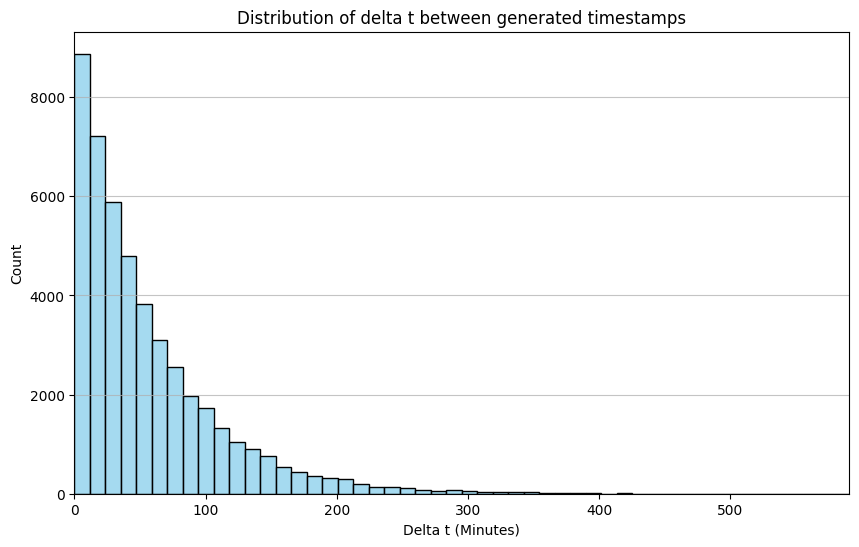

In [18]:
# plot histogram of delta t

time_diff_minutes = time_diff_seconds / 60

plt.figure(figsize=(10, 6))
sns.histplot(time_diff_minutes, kde=False, bins=50, color='skyblue')

plt.xlabel('Delta t (Minutes)')
plt.ylabel('Count')
plt.title('Distribution of delta t between generated timestamps')
plt.grid(axis='y', alpha=0.75)

plt.xlim(0, max(time_diff_minutes))
plt.ylim(bottom=0)


# eCommerce Electronic

In [3]:
# Load eCommerce data

ecom_df = pd.read_csv('/home/filip-marcus/data/kaggle_ecommers_electronic/events.csv')

ecom_df.shape

ecom_df.head(9)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ
5,2020-09-24 11:57:59 UTC,view,664325,2144415951611757447,construction.tools.saw,carver,52.33,1515915625519388062,vnkdP81DDW
6,2020-09-24 11:58:23 UTC,view,3791349,2144415935086199225,computers.desktop,NaN,215.41,1515915625519388877,J1t6sIYXiV
7,2020-09-24 11:58:24 UTC,view,716611,2144415923694469257,computers.network.router,d-link,53.14,1515915625519388882,kVBeYDPcBw
8,2020-09-24 11:58:25 UTC,view,657859,2144415939431498289,NaN,NaN,34.17,1515915625519320570,HEl15U7JVy


In [7]:
# Sort events by user_id
ecom_df.sort_values(by="user_id")

# Create new user_ids ranging from 0 to len (df["user_id"])
unique_users = {old_id: new_id for new_id, old_id in enumerate(ecom_df["user_id"].unique(), start=1)}

# Replace user_id with new unique IDs
ecom_df["user_id"] = ecom_df["user_id"].map(unique_users)-1
print(ecom_df.head())

                event_time event_type  product_id          category_id  \
0  2020-09-24 11:57:06 UTC       view     1996170  2144415922528452715   
1  2020-09-24 11:57:26 UTC       view      139905  2144415926932472027   
2  2020-09-24 11:57:27 UTC       view      215454  2144415927158964449   
3  2020-09-24 11:57:33 UTC       view      635807  2144415923107266682   
4  2020-09-24 11:57:36 UTC       view     3658723  2144415921169498184   

                   category_code        brand   price  user_id user_session  
0          electronics.telephone          NaN   31.90        0   LJuJVLEjPT  
1    computers.components.cooler       zalman   17.16        1   tdicluNnRY  
2                            NaN          NaN    9.81        2   4TMArHtXQy  
3  computers.peripherals.printer       pantum  113.81        3   aGFYrNgC08  
4                            NaN  cameronsino   15.87        4   aa4mmk0kwQ  


In [8]:
# Drop 'user_session' column
ecom_df.drop(columns=['user_session'], inplace=True)

In [9]:
# df = ecom_df.iloc[:,:]
df = ecom_df
df = df[[df.columns[-1]] + list(df.columns[:-1])]
unique_classes = ecom_df['event_type'].unique()
#print(unique_classes)

df["event_time"] = df["event_time"].str.replace(" UTC", "", regex=False)
df['event_label'] = df['event_type']
df.drop(columns=['event_type'], inplace = True)
pd.set_option("display.max_rows",10)


# split the dataframe into a separate dataframe for each event_label
dfs = {event: df[df['event_label'] == event] for event in unique_classes}

save_dir = '/home/filip-marcus/ESGPT_test/data/ecom/pretrain'
# for event, df_event in dfs.items():
#     df_event.to_csv(f"{save_dir}/df_ecom_{event}_full.csv",index=False)
df.to_csv(f"{save_dir}/df_ecom_electronic_event_full.csv",index=False)

### Finetune

In [ ]:
# Selectthe first 10 000 events
df = ecom_df.iloc[:10000,:]
print(df.head())
df = df[[df.columns[-1]] + list(df.columns[:-1])]
print(df.head())
unique_classes = ecom_df['event_type'].unique()
print(unique_classes)
print(df.shape)

df["event_time"] = df["event_time"].str.replace(" UTC", "", regex=False)
df['event_label'] = df['event_type']
df.drop(columns=['event_type'], inplace = True)
df

# Check if there exists more than one event for each user
duplicates_mask = df.duplicated(subset="user_id",keep=False)
df = df[duplicates_mask]
df.sort_values(by="user_id",inplace=True,ignore_index=False)
subjects = df["user_id"].unique()

for subject in subjects:
    subject_rows_indices = df.index[df["user_id"] == subject].tolist() # Get indices of rows for subject

    num_events = len(subject_rows_indices)
    random_index_pos = random.randint(0,num_events-1) 
    index_to_mask = subject_rows_indices[random_index_pos] 

   
    df.loc[index_to_mask, "event_label"] = "MASKED" 

    

unique_classes = df['event_label'].unique()
# split the dataframe into a separate dataframe for each event_label
dfs = {event: df[df['event_label'] == event] for event in unique_classes}
print(dfs.keys())
save_dir = '/home/filip-marcus/ESGPT_test/data'
for event, df_event in dfs.items():
    df_event.to_csv(f"{save_dir}/df_ecom_proxy_task_event_type_imputation_{event}.csv",index=False)

### Subjects

In [10]:
subject_df = pd.DataFrame({'user_id': df['user_id'].unique()})  # change df to ecom_df if you want full dataset

subject_df['dummy_static'] = 1

subject_df.to_csv('/home/filip-marcus/ESGPT_test/data/ecom/pretrain/subjects_ecom_full.csv', index=False)
subject_df

,user_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
407278,407278,1
407279,407279,1
407280,407280,1
407281,407281,1


# eCommerce cosmetics

In [12]:
raw_data_dir_ecom_cosmetics = '/home/filip-marcus/data/kaggle_ecommerce_cosmetics'
ecom_cosm_dec_19_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2019-Dec.csv")
ecom_cosm_dec_19_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [13]:
ecom_cosm_nov_19_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2019-Nov.csv")

ecom_cosm_nov_19_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


In [14]:
ecom_cosm_oct_19_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2019-Oct.csv")

ecom_cosm_oct_19_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [15]:
ecom_cosm_feb_20_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2020-Feb.csv")

# Removing rows that has price of other datatype than float
ecom_cosm_feb_20_df['price_numeric'] = pd.to_numeric(ecom_cosm_feb_20_df['price'], errors='coerce')

ecom_cosm_feb_20_df = ecom_cosm_feb_20_df[~ecom_cosm_feb_20_df['price_numeric'].isnull()]
ecom_cosm_feb_20_df.drop(['price_numeric'],inplace=True, axis=1)


ecom_cosm_feb_20_df.head()

/tmp/ipykernel_4146911/700841090.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ecom_cosm_feb_20_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2020-Feb.csv")


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-02-01 00:00:01 UTC,cart,5844305,1487580006317032337,NaN,NaN,2.14,485174092,4be9643a-420b-4c6b-83dd-a15e772fbf7a
1,2020-02-01 00:00:03 UTC,view,5769925,1487580013841613016,NaN,kapous,4.22,594621622,a88baf11-9cd0-4362-bde4-1bfeed3f641d
2,2020-02-01 00:00:08 UTC,view,5817765,1487580008246412266,NaN,zeitun,11.03,495404942,3a569c8d-d848-4f09-a925-33f673d84c46
3,2020-02-01 00:00:11 UTC,view,5877033,1487580010100293687,NaN,milv,3.49,564814969,7feb39e5-bb7b-4b2b-a546-3e3b7c56326e
4,2020-02-01 00:00:12 UTC,cart,5814871,1487580008112194531,NaN,zinger,2.54,551205603,106a7c7f-7fa1-4463-8bec-0ea7b02191cb


In [16]:
ecom_cosm_Jan_20_df = pd.read_csv(raw_data_dir_ecom_cosmetics+"/2020-Jan.csv")

ecom_cosm_Jan_20_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


In [13]:
# Append the above dataframe into one
ecom_cosm_df = pd.concat([ecom_cosm_dec_19_df,ecom_cosm_oct_19_df,ecom_cosm_nov_19_df,ecom_cosm_feb_20_df,ecom_cosm_Jan_20_df], axis=0,ignore_index=True)

# Drop columns "user_sesion"
ecom_cosm_df.drop("user_session",inplace=True,axis=1)

# Move column "user_id" to the front
ecom_cosm_df = ecom_cosm_df[[ecom_cosm_df.columns[-1]] + list(ecom_cosm_df.columns[:-1])]

# Sort events by user_id
ecom_cosm_df.sort_values(by="user_id")

# Create new user_ids ranging from 0 to len (df["user_id"])
unique_users = {old_id: new_id for new_id, old_id in enumerate(ecom_cosm_df["user_id"].unique(), start=1)}

# Replace user_id with new unique IDs
ecom_cosm_df["user_id"] = ecom_cosm_df["user_id"].map(unique_users)-1
ecom_cosm_df.head()



,user_id,event_time,event_type,product_id,category_id,category_code,brand,price
0,0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27
1,1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05
2,2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19
3,3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79
4,4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56


In [33]:
# Save DataFrame as .csv file
ecom_cosm_df.to_csv("/home/filip-marcus/ESGPT_test/data/ecom_cosmetic/pretrain/ecom_cosmetic_event_full.csv")

### Subjects

In [38]:
subject_ecom_cosm_list = ecom_cosm_df["user_id"].to_list()
subject_ecom_cosm_df = pd.DataFrame(subject_ecom_cosm_list,columns=["user_id"])
subject_ecom_cosm_df["dummy_static"] = 1
subject_ecom_cosm_df.to_csv("/home/filip-marcus/ESGPT_test/data/ecom_cosmetic/pretrain/subjects_cosmetics.csv")

# MIMIC-IV-Demo

In [4]:
raw_data_dir_mimic = "/home/filip-marcus/data/mimic_data/physionet.org/files/mimic-iv-ed-demo/2.2/ed"

mimic_diagnosis_df = pd.read_csv(raw_data_dir_mimic + "/diagnosis.csv.gz")
mimic_diagnosis_df.to_csv("/home/filip-marcus/ESGPT_test/data/diagnosis_mimic_demo.csv")
mimic_diagnosis_df.head()

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title
0,10025463,35470228,1,431,9,INTRACEREBRAL HEMORRHAGE
1,10027602,36678718,1,431,9,INTRACEREBRAL HEMORRHAGE
2,10009049,31628990,1,486,9,"PNEUMONIA,ORGANISM UNSPECIFIED"
3,10014078,38676365,1,3453,9,GRAND MAL STATUS
4,10007928,39661025,1,5780,9,HEMATEMESIS


In [5]:
mimic_edstays_df = pd.read_csv(raw_data_dir_mimic + "/edstays.csv.gz")
mimic_edstays_df.to_csv("/home/filip-marcus/ESGPT_test/data/edstays_mimic_demo.csv")
mimic_edstays_df.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
0,10014729,23300884.0,37887480,2125-03-19 12:36:00,2125-03-19 16:59:47,F,WHITE - OTHER EUROPEAN,WALK IN,ADMITTED
1,10018328,26706939.0,34176810,2154-02-05 17:09:00,2154-02-05 22:54:00,F,WHITE,AMBULANCE,ADMITTED
2,10018328,NaN,32103106,2154-08-03 15:31:00,2154-08-03 22:29:00,F,WHITE,AMBULANCE,HOME
3,10020640,27984218.0,38797992,2153-02-12 21:59:00,2153-02-13 01:38:00,F,WHITE,AMBULANCE,ADMITTED
4,10015272,27993466.0,33473053,2137-06-12 16:54:00,2137-06-12 18:37:22,F,WHITE,AMBULANCE,ADMITTED


In [6]:
mimic_medrecon_df = pd.read_csv(raw_data_dir_mimic + "/medrecon.csv.gz")
mimic_medrecon_df.to_csv("/home/filip-marcus/ESGPT_test/data/medrecon_mimic_demo.csv")

mimic_medrecon_df.head()

,subject_id,stay_id,charttime,name,gsn,ndc,etc_rn,etccode,etcdescription
0,10023117,31283645,2171-11-07 20:38:00,*acuvite,0,0,1,NaN,NaN
1,10038999,34205403,2132-05-17 21:17:00,*depakote DR,0,0,1,NaN,NaN
2,10002428,38216551,2160-07-15 19:43:00,*nutrient drink,0,0,1,NaN,NaN
3,10016742,33335871,2178-07-22 06:08:00,*iron liquid,0,0,1,NaN,NaN
4,10040025,32034003,2143-03-10 23:20:00,amoxicillin,8996,10544054615,1,3.0,Aminopenicillin Antibiotic


In [7]:
mimic_pyxis_df = pd.read_csv(raw_data_dir_mimic + "/pyxis.csv.gz")
mimic_pyxis_df.to_csv("/home/filip-marcus/ESGPT_test/data/pyxis_mimic_demo.csv")

mimic_pyxis_df.head()

,subject_id,stay_id,charttime,med_rn,name,gsn_rn,gsn
0,10012853,36185653,2175-04-05 06:39:00,4,Aspirin,1,4380.0
1,10040025,37401157,2145-10-19 23:53:00,2,Aspirin,1,4380.0
2,10014354,30279522,2149-09-17 11:51:00,2,Aspirin,1,4380.0
3,10040025,30836087,2145-07-04 10:27:00,10,Aspirin,1,4380.0
4,10032725,30701739,2143-03-22 21:48:00,2,Aspirin,1,4376.0


In [8]:
mimic_triage_df = pd.read_csv(raw_data_dir_mimic + "/triage.csv.gz")
mimic_triage_df.to_csv("/home/filip-marcus/ESGPT_test/data/triage_mimic_demo.csv")
mimic_triage_df.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10016742,33211001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PICC EVAL
1,10032725,30701739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FACIAL DROOP
2,10010867,30115213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVC/INTUBATED TRAUMA
3,10004235,38926302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S/P ARREST
4,10027602,36678718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEAD BLEED


In [9]:
mimic_vitalsign_df = pd.read_csv(raw_data_dir_mimic + "/vitalsign.csv.gz")
mimic_vitalsign_df.to_csv("/home/filip-marcus/ESGPT_test/data/vitalsign_mimic_demo.csv")
mimic_vitalsign_df.head()

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10014729,37887480,2125-03-19 13:22:00,NaN,124.0,24.0,100.0,93.0,65.0,NaN,NaN
1,10014729,37887480,2125-03-19 18:28:00,98.9,106.0,18.0,100.0,115.0,70.0,Sinus Tachycardia,5
2,10014729,37887480,2125-03-19 13:07:00,NaN,128.0,18.0,100.0,132.0,96.0,Sinus Tachycardia,NaN
3,10014729,37887480,2125-03-19 16:23:00,99.8,115.0,22.0,97.0,114.0,45.0,Sinus Tachycardia,0
4,10014729,37887480,2125-03-19 13:24:00,NaN,125.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
subject_list = mimic_diagnosis_df['subject_id'].to_list()
subject_df = pd.DataFrame(subject_list,columns=["subject_id"])
subject_df['dummy_static'] = 1

subject_df.to_csv("/home/filip-marcus/ESGPT_test/data/subjects_mimic_demo.csv")
subject_df.head()

,subject_id,dummy_static
0,10025463,1
1,10027602,1
2,10009049,1
3,10014078,1
4,10007928,1


# Predictive maintenance

In [18]:
raw_data_dir_predicitve_maintenance = "/home/filip-marcus/data/predictive_maintenance"
pred_maintenance_df = pd.read_csv(raw_data_dir_predicitve_maintenance + "/predictive_maintenance_dataset.csv")
print(pred_maintenance_df.shape)
pred_maintenance_df.tail(40)

(124494, 12)


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
124454,10/31/2015,Z1F0GB8A,0,170308872,0,0,0,9,355070,0,0,0
124455,10/31/2015,Z1F0GE1M,0,235777792,0,0,0,10,349229,0,0,0
124456,10/31/2015,Z1F0KJDS,0,161935008,0,0,0,11,355984,0,0,0
124457,10/31/2015,Z1F0KKN4,0,171609168,0,0,0,9,350844,0,0,0
124458,10/31/2015,Z1F0MA1S,0,184310392,0,0,0,10,353052,0,0,0
124459,10/31/2015,Z1F0Q8RT,0,184353576,96,107,4,11,332166,0,0,13
124460,10/31/2015,Z1F0QK05,0,30912880,4832,0,0,11,349802,0,0,0
124461,10/31/2015,Z1F0QL3N,0,62018104,0,0,0,12,356937,0,0,0
124462,10/31/2015,Z1F0QLC1,0,32117368,0,0,0,10,350840,0,0,0
124463,11/2/2015,S1F0E9EP,0,205465736,0,0,12,11,353337,0,0,0


In [19]:
# Move column "user_id" to the front

pred_maintenance_df = pred_maintenance_df[[pred_maintenance_df.columns[1]] + [pred_maintenance_df.columns[0]] + list(pred_maintenance_df.columns[2:])]
pred_maintenance_df.head()

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,S1F01085,1/1/2015,0,215630672,55,0,52,6,407438,0,0,7
1,S1F0166B,1/1/2015,0,61370680,0,3,0,6,403174,0,0,0
2,S1F01E6Y,1/1/2015,0,173295968,0,0,0,12,237394,0,0,0
3,S1F01JE0,1/1/2015,0,79694024,0,0,0,6,410186,0,0,0
4,S1F01R2B,1/1/2015,0,135970480,0,0,0,15,313173,0,0,3


In [60]:

# Sort events by user_id
pred_maintenance_df.sort_values(by="device")

# Create new user_ids ranging from 0 to len (df["user_id"])
unique_users = {old_id: new_id for new_id, old_id in enumerate(pred_maintenance_df["device"].unique(), start=1)}

# Replace user_id with new unique IDs
pred_maintenance_df["device"] = pred_maintenance_df["device"].map(unique_users)-1

pred_maintenance_df.to_csv("/home/filip-marcus/ESGPT_test/data/predictive_maintenance/pretrain/predicitve_maintenance_events_df.csv")
pred_maintenance_df.tail()


,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,0,1/1/2015,0,215630672,55,0,52,6,407438,0,0,7
1,1,1/1/2015,0,61370680,0,3,0,6,403174,0,0,0
2,2,1/1/2015,0,173295968,0,0,0,12,237394,0,0,0
3,3,1/1/2015,0,79694024,0,0,0,6,410186,0,0,0
4,4,1/1/2015,0,135970480,0,0,0,15,313173,0,0,3


In [63]:
subject_pred_maintenance_list = pred_maintenance_df['device'].to_list()
subject_pred_maintenance_df = pd.DataFrame(subject_pred_maintenance_list,columns=["device"])
subject_pred_maintenance_df['dummy_static'] = 1

subject_pred_maintenance_df.to_csv("/home/filip-marcus/ESGPT_test/data/predictive_maintenance/pretrain/subject_pred_maintenance.csv")
subject_pred_maintenance_df.head()

,device,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


# Metro pt

In [20]:
raw_data_dir_metro = "/home/filip-marcus/data/metro_pt/"
metro_pt_df = pd.read_csv(raw_data_dir_metro + "dataset_train.csv")


/tmp/ipykernel_4146911/4033347150.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  metro_pt_df = pd.read_csv(raw_data_dir_metro + "dataset_train.csv")


In [21]:

print(metro_pt_df.columns)
metro_pt_df.head()

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')


,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality
0,2022-01-01 06:00:00,-0.012,9.758,9.760,-0.028,1.576,63.350,19.049625,3.9550,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1.0
1,2022-01-01 06:00:01,-0.012,9.760,9.760,-0.028,1.578,63.250,19.049625,4.0275,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1.0
2,2022-01-01 06:00:02,-0.010,9.760,9.760,-0.028,1.578,63.325,19.040281,3.9450,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1.0
3,2022-01-01 06:00:03,-0.012,9.756,9.756,-0.030,1.576,63.200,19.040281,3.9300,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1.0
4,2022-01-01 06:00:04,-0.012,9.756,9.756,-0.030,1.578,63.150,19.049625,3.9950,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1.0


# Megamind

In [3]:
raw_data_dir_mimic = "/home/filip-marcus/data/mimic_data/physionet.org/files/mimic-iv-ed-demo/2.2/ed"

mimic_pyxis_df = pd.read_csv(raw_data_dir_mimic + "/pyxis.csv.gz")
mimic_pyxis_df.sort_values(by="subject_id",inplace=True)
mimic_medrecon_df = pd.read_csv(raw_data_dir_mimic + "/medrecon.csv.gz")
mimic_medrecon_df.sort_values(by="subject_id",inplace=True)
mimic_edstays_df = pd.read_csv(raw_data_dir_mimic + "/edstays.csv.gz")
mimic_edstays_df.sort_values(by="subject_id", inplace=True)
mimic_vitalsign_df = pd.read_csv(raw_data_dir_mimic + "/vitalsign.csv.gz")
mimic_vitalsign_df.sort_values(by="subject_id", inplace=True)
ecom_electronic_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/ecom_electronic/pretrain/df_ecom_electronic_event_full.csv')
ecom_cosm_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/ecom_cosmetic/pretrain/ecom_cosmetic_event_full.csv',index_col=0)
pred_maintenance_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/predictive_maintenance/pretrain/predicitve_maintenance_events_df.csv',index_col=0)
eneryield_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_events_df.csv', index_col=0)

In [ ]:

# pred_maintenance_df.drop(columns=["product_id", "category_id", "category_code", "brand"], inplace=True)

# print(pred_maintenance_df.nunique())
# print(pred_maintenance_df.head())




device       1169
date          304
failure         2
metric1    123877
metric2       560
metric3        48
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        67
dtype: int64
   device      date  failure    metric1  metric2  metric3  metric4  metric5  \
0       0  1/1/2015        0  215630672       55        0       52        6   
1       1  1/1/2015        0   61370680        0        3        0        6   
2       2  1/1/2015        0  173295968        0        0        0       12   
3       3  1/1/2015        0   79694024        0        0        0        6   
4       4  1/1/2015        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  


In [19]:
# change subject_id col to index
mimic_unique_users1 = {old_id: new_id for new_id, old_id in enumerate(mimic_pyxis_df["subject_id"].unique(), start=1)}
mimic_unique_users2= {old_id: new_id for new_id, old_id in enumerate(mimic_medrecon_df["subject_id"].unique(), start=1)}
mimic_unique_users3 = {old_id: new_id for new_id, old_id in enumerate(mimic_edstays_df["subject_id"].unique(), start=1)}
mimic_unique_users4 = {old_id: new_id for new_id, old_id in enumerate(mimic_vitalsign_df["subject_id"].unique(), start=1)}

mimic_ids = pd.concat([mimic_pyxis_df["subject_id"], mimic_medrecon_df["subject_id"], mimic_edstays_df["subject_id"],mimic_vitalsign_df["subject_id"]]).reset_index(drop=True)

max_mimic_subject_id = max(mimic_ids)

print(max_mimic_subject_id)

10040025


In [20]:
# keep original subject-ids for mimic dataset, then enumerate for the other datasets. This order was used: mimic, eneryield, ecom_electronic, ecom_cosmetics, pred_maintenance

# change name to subject id in all datasets!!!


eneryield_df['sequence_id'] = eneryield_df['sequence_id'] + max_mimic_subject_id + 1
eneryield_df.rename(columns={'sequence_id': 'subject_id'}, inplace=True)

start_idx = max(eneryield_df['subject_id'])
ecom_electronic_df['user_id'] = ecom_electronic_df['user_id'] + start_idx + 1
ecom_electronic_df.rename(columns={'user_id': 'subject_id'}, inplace=True)

start_idx = max(ecom_electronic_df['subject_id'])
ecom_cosm_df['user_id'] = ecom_cosm_df['user_id'] + start_idx + 1
ecom_cosm_df.rename(columns={'user_id': 'subject_id'}, inplace=True)

start_idx = max(ecom_cosm_df['subject_id'])
pred_maintenance_df['device'] = pred_maintenance_df['device'] + start_idx + 1
pred_maintenance_df.rename(columns={'device': 'subject_id'}, inplace=True)
pred_maintenance_df

,subject_id,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,12088087,1/1/2015,0,215630672,55,0,52,6,407438,0,0,7
1,12088088,1/1/2015,0,61370680,0,3,0,6,403174,0,0,0
2,12088089,1/1/2015,0,173295968,0,0,0,12,237394,0,0,0
3,12088090,1/1/2015,0,79694024,0,0,0,6,410186,0,0,0
4,12088091,1/1/2015,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,12089126,11/2/2015,0,18310224,0,0,0,10,353705,8,8,0
124490,12089149,11/2/2015,0,172556680,96,107,4,11,332792,0,0,13
124491,12089156,11/2/2015,0,19029120,4832,0,0,11,350410,0,0,0
124492,12089162,11/2/2015,0,226953408,0,0,0,12,358980,0,0,0


In [26]:
# create megamind subjects.csv

subjects_megamind = pd.concat([mimic_ids, eneryield_df['subject_id'], ecom_electronic_df['subject_id'], ecom_cosm_df['subject_id'], pred_maintenance_df['subject_id']],axis=0)
subjects_megamind = pd.DataFrame(subjects_megamind, columns=["subject_id"])

subjects_megamind['dummy_static'] = 1

subjects_megamind

,subject_id,dummy_static
0,10000032,1
1,10000032,1
2,10000032,1
3,10000032,1
4,10000032,1
...,...,...
124489,12089126,1
124490,12089149,1
124491,12089156,1
124492,12089162,1


In [22]:
# remove UTC from ecom_cosmetic event_time
ecom_cosm_df["event_time"] = ecom_cosm_df["event_time"].str.replace(" UTC", "", regex=False)
ecom_cosm_df

,subject_id,event_time,event_type,price
0,10448729,2019-12-01 00:00:00,remove_from_cart,6.27
1,10448730,2019-12-01 00:00:00,view,29.05
2,10448731,2019-12-01 00:00:02,cart,1.19
3,10448732,2019-12-01 00:00:05,view,0.79
4,10448733,2019-12-01 00:00:07,view,5.56
...,...,...,...,...
20692834,11461291,2020-01-31 23:59:52,remove_from_cart,1.59
20692835,11461291,2020-01-31 23:59:52,remove_from_cart,1.59
20692836,10708479,2020-01-31 23:59:53,view,2.05
20692837,11461291,2020-01-31 23:59:57,remove_from_cart,2.22


In [23]:
# rename event_type to event_label in ecom_cosmetic
ecom_cosm_df['event_label'] = ecom_cosm_df['event_type']
ecom_cosm_df.drop(columns=['event_type'], inplace = True)
ecom_cosm_df

,subject_id,event_time,price,event_label
0,10448729,2019-12-01 00:00:00,6.27,remove_from_cart
1,10448730,2019-12-01 00:00:00,29.05,view
2,10448731,2019-12-01 00:00:02,1.19,cart
3,10448732,2019-12-01 00:00:05,0.79,view
4,10448733,2019-12-01 00:00:07,5.56,view
...,...,...,...,...
20692834,11461291,2020-01-31 23:59:52,1.59,remove_from_cart
20692835,11461291,2020-01-31 23:59:52,1.59,remove_from_cart
20692836,10708479,2020-01-31 23:59:53,2.05,view
20692837,11461291,2020-01-31 23:59:57,2.22,remove_from_cart


In [25]:
# keep only 1% of ecom_cosmetics

ecom_cosm_df_01 = ecom_cosm_df.iloc[:int(len(ecom_cosm_df) * 0.001)]
ecom_cosm_df_01

,subject_id,event_time,price,event_label
0,10448729,2019-12-01 00:00:00,6.27,remove_from_cart
1,10448730,2019-12-01 00:00:00,29.05,view
2,10448731,2019-12-01 00:00:02,1.19,cart
3,10448732,2019-12-01 00:00:05,0.79,view
4,10448733,2019-12-01 00:00:07,5.56,view
...,...,...,...,...
20687,10451965,2019-12-01 08:19:40,12.06,view
20688,10451888,2019-12-01 08:19:41,1.59,remove_from_cart
20689,10451888,2019-12-01 08:19:41,1.59,remove_from_cart
20690,10451966,2019-12-01 08:19:41,5.24,view


In [27]:
# save files
save_dir = '/home/filip-marcus/ESGPT_test/data/megamind/pretrain'

mimic_edstays_df.to_csv(save_dir + '/mimic_edstays_df_small_vocab.csv')
mimic_pyxis_df.to_csv(save_dir + '/mimic_pyxis_df_small_vocab.csv')
mimic_medrecon_df.to_csv(save_dir + '/mimic_medrecon_df_small_vocab.csv')
mimic_vitalsign_df.to_csv(save_dir + '/mimic_vitalsign_df_small_vocab.csv')

eneryield_df.to_csv(save_dir + '/eneryield_df.csv')
ecom_electronic_df.to_csv(save_dir + '/ecom_electronic_df_small_vocab.csv')

# ecom_cosm_df.to_csv(save_dir + '/ecom_cosmetic_df_small_vocab.csv')

ecom_cosm_df_01.to_csv(save_dir + '/ecom_cosmetic_df_01_small_vocab.csv')

pred_maintenance_df.to_csv(save_dir + '/predictive_maintenance.csv')

subjects_megamind.to_csv(save_dir + '/subjects_megamind_small_vocab.csv', index=False)

In [ ]:
# print total size of megamind dataset

total_rows = mimic_edstays_df.shape[0] + mimic_medrecon_df.shape[0] + mimic_pyxis_df.shape[0] + mimic_vitalsign_df.shape[0] + eneryield_df.shape[0] + ecom_electronic_df.shape[0] + ecom_cosm_df_01.shape[0] + pred_maintenance_df.shape[0]
print(f'Total number of rows (events) in MEGAMIND: {total_rows / 10**6} M')

Total number of rows (events) in MEGAMIND: 1.55379 M


In [26]:
subjects_megamind

,subject_id,dummy_static
0,10000032,1
1,10000032,1
2,10000032,1
3,10000032,1
4,10000032,1
...,...,...
124489,12089126,1
124490,12089149,1
124491,12089156,1
124492,12089162,1


In [20]:
df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_events_df.csv')
df_new = df.iloc[:10000, :6]
df_new['feature_0'] = 1
df_new

,Unnamed: 0,sequence_id,event_idx,timestamp,event_label,feature_0
0,40,0,40,2025-02-01 13:51:48,unbalance_i,1
1,41,0,41,2025-02-01 13:53:09,unbalance_i,1
2,114,1,40,2025-02-01 13:51:48,unbalance_i,1
3,115,1,41,2025-02-01 13:53:09,unbalance_i,1
4,196,3,41,2025-01-24 07:02:57,unbalance_i,1
...,...,...,...,...,...,...
9995,27113,244,23,2024-06-02 05:41:59,harmonics_i,1
9996,27114,244,24,2024-06-02 05:42:30,harmonics_i,1
9997,27117,244,27,2024-06-02 05:43:28,harmonics_i,1
9998,27118,244,28,2024-06-02 05:44:39,harmonics_i,1


In [ ]:
test_subjects = pd.DataFrame({'sequence_id': df_new['sequence_id'].unique()})
test_subjects['dummy_static'] = 1
test_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,3,1
3,4,1
4,5,1
...,...,...
236,240,1
237,241,1
238,242,1
239,243,1


In [22]:
df_new.to_csv('/home/filip-marcus/ESGPT_test/data/simple/test_events.csv')
test_subjects.to_csv('/home/filip-marcus/ESGPT_test/data/simple/test_subjects.csv')

In [27]:
eneryield_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield/pretrain/eneryield_small_lookback_7.csv')
ecom_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/ecom_electronic/pretrain/df_ecom_electronic_event_full.csv')



In [28]:
ecom_df['user_id'] = ecom_df['user_id'] + max(eneryield_df['sequence_id']) + 1


eneryield_ecom_subjects = pd.DataFrame({'sequence_id': (pd.concat([eneryield_df['sequence_id'], ecom_df['user_id']], axis= 0)).unique()})
eneryield_ecom_subjects['dummy_static'] = 1
eneryield_ecom_subjects


,sequence_id,dummy_static
0,0,1
1,1,1
2,3,1
3,4,1
4,5,1
...,...,...
408687,408698,1
408688,408699,1
408689,408700,1
408690,408701,1


In [29]:
ecom_df['sequence_id'] = ecom_df['user_id']
ecom_df.drop(columns=['product_id', "category_id", "category_code", "brand","user_id"], inplace=True)
ecom_df

,event_time,price,event_label,sequence_id
0,2020-09-24 11:57:06,31.90,view,1420
1,2020-09-24 11:57:26,17.16,view,1421
2,2020-09-24 11:57:27,9.81,view,1422
3,2020-09-24 11:57:33,113.81,view,1423
4,2020-09-24 11:57:36,15.87,view,1424
...,...,...,...,...
885124,2021-02-28 23:55:01,219.94,view,408699
885125,2021-02-28 23:58:05,80.03,view,408700
885126,2021-02-28 23:58:09,64.92,view,408701
885127,2021-02-28 23:58:14,10.16,view,408702


In [30]:
ecom_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom/pretrain/ecom_df.csv')
eneryield_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom/pretrain/eneryield_df.csv')
eneryield_ecom_subjects.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom/pretrain/subjects.csv')

### Eneryield - Ecom Electronic - Predictive Maintenance

In [ ]:
eneryield_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom/pretrain/eneryield_df.csv')
ecom_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom/pretrain/ecom_df.csv')
pred_main_df = pd.read_csv('/home/filip-marcus/ESGPT_test/data/predictive_maintenance/pretrain/predicitve_maintenance_events_df.csv')

In [ ]:
# fix pred_main subjects
pred_main_df['device'] = pred_main_df['device'] + max(ecom_df['sequence_id']) + 1
pred_main_df['sequence_id'] = pred_main_df['device']

pred_main_df.drop(columns=["device"],inplace=True)
pred_main_df

,Unnamed: 0,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,sequence_id
0,0,1/1/2015,0,215630672,55,0,52,6,407438,0,0,7,408703
1,1,1/1/2015,0,61370680,0,3,0,6,403174,0,0,0,408704
2,2,1/1/2015,0,173295968,0,0,0,12,237394,0,0,0,408705
3,3,1/1/2015,0,79694024,0,0,0,6,410186,0,0,0,408706
4,4,1/1/2015,0,135970480,0,0,0,15,313173,0,0,3,408707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,124489,11/2/2015,0,18310224,0,0,0,10,353705,8,8,0,409742
124490,124490,11/2/2015,0,172556680,96,107,4,11,332792,0,0,13,409765
124491,124491,11/2/2015,0,19029120,4832,0,0,11,350410,0,0,0,409772
124492,124492,11/2/2015,0,226953408,0,0,0,12,358980,0,0,0,409778


In [41]:
eneryield_ecom_pred_subjects = pd.DataFrame({'sequence_id': (pd.concat([eneryield_df['sequence_id'], ecom_df['sequence_id'], pred_main_df['sequence_id']], axis= 0)).unique()})
eneryield_ecom_pred_subjects['dummy_static'] = 1
eneryield_ecom_pred_subjects


,sequence_id,dummy_static
0,0,1
1,1,1
2,3,1
3,4,1
4,5,1
...,...,...
409856,409867,1
409857,409868,1
409858,409869,1
409859,409870,1


In [ ]:
ecom_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom_pred/pretrain/ecom_df.csv')
eneryield_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom_pred/pretrain/eneryield_df.csv')
pred_main_df.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom_pred/pretrain/pred_main_df.csv')
eneryield_ecom_subjects.to_csv('/home/filip-marcus/ESGPT_test/data/eneryield_ecom_pred/pretrain/subjects.csv')

### SYNTHETIC V0

In [6]:
import numpy as np

num_event_seq = 10000
num_events = 20
sequence_duration = pd.Timedelta(weeks=1)
rampup_duration = 25

# Generate start timestamps (each sequence starts right after the previous one)
start_dates = [pd.Timestamp("2015-01-01")]

for _ in range(1, num_event_seq):
    start_dates.append(start_dates[-1] + sequence_duration)  # Each sequence starts after the previous one

timestamps = []
sequence_ids = []

for seq_id, start_date in enumerate(start_dates, 1):
    event_times = pd.date_range(start=start_date, end=start_date+sequence_duration, periods=num_events).round('S')  # 20 events per week
    timestamps.extend(event_times)
    sequence_ids.extend([seq_id] * num_events)

df = pd.DataFrame({"timestamp": timestamps, "sequence_id": sequence_ids})

# Assign event_id (resets for each sequence)
df["event_id"] = df.groupby("sequence_id").cumcount()

# Initialize columns
df["feature_1"] = np.random.normal(1, 0.2, size=len(df))  # Random normal values
df["event_label"] = "simple_event"
df["sequence_id"] = df["sequence_id"] - 1  # Adjust sequence_id to start from 0

interruption_indices = np.random.choice(df.index, size=int(num_event_seq*num_events*0.03), replace=False)
for idx in interruption_indices:
    df.at[idx, "event_label"] = "interruption"
    df.at[idx, "feature_1"] = np.random.normal(-1,0.2) # -1


# for event_seq in range(num_event_seq):
#     interruption = np.random.choice([True, False])

    # if interruption:
    #     start_idx = event_seq*num_events
    #     end_idx = start_idx + num_events
    

for interruption_idx in sorted(interruption_indices):
    for i in range(rampup_duration):
        if interruption_idx-1-i in interruption_indices:
            break

        df.iloc[interruption_idx-1-i, 3] = rampup_duration - i + np.random.normal(0, 0.2)
        # df.iloc[end_idx-1, 4] = "interruption"


        
pd.set_option('display.max_rows', 10)
df



,timestamp,sequence_id,event_id,feature_1,event_label
0,2015-01-01 00:00:00,0,0,17.285073,simple_event
1,2015-01-01 08:50:32,0,1,18.196128,simple_event
2,2015-01-01 17:41:03,0,2,19.295252,simple_event
3,2015-01-02 02:31:35,0,3,20.237069,simple_event
4,2015-01-02 11:22:06,0,4,21.066262,simple_event
...,...,...,...,...,...
199995,2206-08-26 12:37:54,9999,15,11.915759,simple_event
199996,2206-08-26 21:28:25,9999,16,13.017772,simple_event
199997,2206-08-27 06:18:57,9999,17,13.816076,simple_event
199998,2206-08-27 15:09:28,9999,18,15.171910,simple_event


In [7]:
pd.set_option('display.max_rows', 300)
df.head(300)


,timestamp,sequence_id,event_id,feature_1,event_label
0,2015-01-01 00:00:00,0,0,17.285073,simple_event
1,2015-01-01 08:50:32,0,1,18.196128,simple_event
2,2015-01-01 17:41:03,0,2,19.295252,simple_event
3,2015-01-02 02:31:35,0,3,20.237069,simple_event
4,2015-01-02 11:22:06,0,4,21.066262,simple_event
5,2015-01-02 20:12:38,0,5,21.770256,simple_event
6,2015-01-03 05:03:09,0,6,23.043808,simple_event
7,2015-01-03 13:53:41,0,7,24.327201,simple_event
8,2015-01-03 22:44:13,0,8,24.810424,simple_event
9,2015-01-04 07:34:44,0,9,-1.100791,interruption


In [8]:
simple_subjects = pd.Series(range(0, num_event_seq))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1 #np.arange(1,num_event_seq+1)  #np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32], size=num_event_seq, replace=False)
# simple_subjects.iloc[0,1] = 2
# simple_subjects.iloc[3,1] = 3
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,1
9998,9998,1


In [9]:
df.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_2.csv')
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_2.csv')


### Synthetic V3

In [2]:
df = pd.DataFrame(columns=['timestamp', 'subject_id', 'event_id', 'feature'])
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2206-01-01')

rampup_duration = 25
num_event_seq = 10000
num_events = 20
num_timestamps = num_event_seq * num_events

time_diff_mean_seconds = (end_date - start_date).total_seconds() / num_timestamps
time_diff_seconds = np.random.exponential(scale=time_diff_mean_seconds, size=num_timestamps - 1) # Generate num_timestamps - 1 differences
print('Rate: ', 1 / time_diff_mean_seconds)

timestamps = [start_date]
current_timestamp = start_date
for i, diff in enumerate(time_diff_seconds):
    current_timestamp += pd.Timedelta(seconds=diff)
    current_timestamp = current_timestamp.round('S')
    timestamps.append(current_timestamp)

sequence_ids = np.repeat(np.arange(num_event_seq), num_events)
event_ids = np.tile(np.arange(num_events), num_event_seq)

timestamps.sort()

timestamps = timestamps[:num_timestamps]

df = pd.DataFrame({'timestamp': timestamps})
df['sequence_id'] = sequence_ids
df["event_id"] = event_ids
df['feature_1'] = np.random.normal(1, 1, size=len(df))
df['event_label'] = 'simple_event'



interruption_indices = np.random.choice(df.index, size=int(num_event_seq*num_events*0.03), replace=False)
for idx in interruption_indices:
    df.at[idx, "event_label"] = "interruption"
    df.at[idx, "feature_1"] = np.random.normal(-1,1) # -1    

for interruption_idx in sorted(interruption_indices):
    for i in range(rampup_duration):
        if interruption_idx-1-i in interruption_indices:
            break

        df.iloc[interruption_idx-1-i, 3] = rampup_duration - i + np.random.normal(0, 1)

pd.set_option('display.max_rows', 10)
df

Rate:  3.3182076157377546e-05


,timestamp,sequence_id,event_id,feature_1,event_label
0,2015-01-01 00:00:00,0,0,1.272505,simple_event
1,2015-01-01 02:29:30,0,1,0.806449,simple_event
2,2015-01-01 13:49:13,0,2,0.922801,simple_event
3,2015-01-01 14:19:47,0,3,0.961650,simple_event
4,2015-01-01 15:36:06,0,4,-1.183739,simple_event
...,...,...,...,...,...
199995,2206-01-29 15:44:26,9999,15,2.094312,simple_event
199996,2206-01-29 20:09:24,9999,16,0.521685,simple_event
199997,2206-01-30 18:34:17,9999,17,0.690657,simple_event
199998,2206-01-31 00:35:07,9999,18,-1.269872,simple_event


In [3]:
pd.set_option('display.max_rows', 300)
df.head(300)


,timestamp,sequence_id,event_id,feature_1,event_label
0,2015-01-01 00:00:00,0,0,1.272505,simple_event
1,2015-01-01 02:29:30,0,1,0.806449,simple_event
2,2015-01-01 13:49:13,0,2,0.922801,simple_event
3,2015-01-01 14:19:47,0,3,0.961650,simple_event
4,2015-01-01 15:36:06,0,4,-1.183739,simple_event
5,2015-01-02 04:50:07,0,5,-0.366714,simple_event
6,2015-01-02 17:44:11,0,6,0.751848,simple_event
7,2015-01-02 23:56:12,0,7,0.527989,simple_event
8,2015-01-03 03:50:52,0,8,-0.424357,simple_event
9,2015-01-03 05:33:35,0,9,-0.330306,simple_event


In [4]:
simple_subjects = pd.Series(range(0, num_event_seq))
simple_subjects = pd.DataFrame(simple_subjects, columns=['sequence_id'])
simple_subjects['dummy_static'] = 1
simple_subjects

,sequence_id,dummy_static
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,1
9998,9998,1


In [5]:
df.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_dataset_4.csv')
simple_subjects.to_csv('/home/filip-marcus/preprocessed_data/synthetic/pretrain/synthetic_subjects_4.csv')